# import

In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pylab as plt
import seaborn as sns
import xgboost as xgb
import time

%matplotlib inline

# macro columns

In [7]:
# From here: https://www.kaggle.com/robertoruiz/sberbank-russian-housing-market/dealing-with-multicollinearity/notebook
macro_cols = ["balance_trade", "balance_trade_growth", "eurrub", "average_provision_of_build_contract",
"micex_rgbi_tr", "micex_cbi_tr", "deposits_rate", "mortgage_value", "mortgage_rate",
"income_per_cap", "rent_price_4+room_bus", "museum_visitis_per_100_cap", "apartment_build"]

# preprocess

## construct df_all
df_all 包含所有训练和测试数据，以及全部原始特征

In [108]:
df_train = pd.read_csv("../input/train.csv", parse_dates=['timestamp'])
df_test = pd.read_csv("../input/test.csv", parse_dates=['timestamp'])
df_macro = pd.read_csv("../input/macro.csv", parse_dates=['timestamp'], usecols=['timestamp'] + macro_cols)

# ylog will be log(1+y), as suggested by https://github.com/dmlc/xgboost/issues/446#issuecomment-135555130
ylog_train_all = np.log1p(df_train['price_doc'].values)
id_test = df_test['id']

df_train.drop(['id', 'price_doc'], axis=1, inplace=True)
df_test.drop(['id'], axis=1, inplace=True)

# Build df_all = (df_train+df_test).join(df_macro)
num_train = len(df_train)
df_all = pd.concat([df_train, df_test])
df_all = pd.merge_ordered(df_all, df_macro, on='timestamp', how='left')
print(df_all.shape)

(38133, 303)


## add new features (naive xgb)
基本上是基于时间的
生成计数类特征的手法
1. the_map = df.attr.value_counts().to_dict()
2. attr.map(the_map)

注意dt获取Serie中的数据

In [109]:
# Add month-year
# 新特征 哪年哪月（交易量）
month_year = (df_all.timestamp.dt.month + df_all.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df_all['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
# 新特征 一年中的第几周（交易量）
week_year = (df_all.timestamp.dt.weekofyear + df_all.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df_all['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
# 新特征 几月份（交易 ）和 星期几（交易）
df_all['month'] = df_all.timestamp.dt.month
df_all['dow'] = df_all.timestamp.dt.dayofweek

# Other feature engineering
df_all['rel_floor'] = df_all['floor'] / df_all['max_floor'].astype(float)
df_all['rel_kitch_sq'] = df_all['kitch_sq'] / df_all['full_sq'].astype(float)

## add new features (my)

In [110]:
## add new features (my)

# 非使用面积
df_all['gaoyl_rest_sq'] = df_all.full_sq - df_all.life_sq

# 交易时间 - 建成时间
df_all['gaoyl_time_offset'] = df_all.timestamp.dt.year - df_all.build_year

## add new features(count of area records)

In [111]:
# df_all['year'] = df_all.timestamp.apply(lambda x: x.year)
# year_area_count = df_all.groupby(['year', 'sub_area']).agg('size').reset_index()
# year_area_count.columns = ['year', 'sub_area', 'gaoyl_year_area_count']

# df_all = pd.merge_ordered(df_all, year_area_count, on=['year', 'sub_area'], how='left')
# df_all.drop(['year'], axis=1, inplace=True)

sub_area_map = df_all.sub_area.value_counts().to_dict()
df_all['gaoyl_subarea_cnt'] = df_all.sub_area.map(sub_area_map)

## Remove timestamp column (may overfit the model in train)

In [123]:
to_drop = ['timestampe', 'gaoyl_rest_sq']
df_all.drop(filter(lambda x: x in df_all.columns, to_drop), axis=1, inplace=True)

## construct X_train X_val & X_test

In [124]:
# Deal with categorical values
df_numeric = df_all.select_dtypes(exclude=['object'])
df_obj = df_all.select_dtypes(include=['object']).copy()

for c in df_obj:
    df_obj[c] = pd.factorize(df_obj[c])[0]

df_values = pd.concat([df_numeric, df_obj], axis=1)

f_values = pd.concat([df_numeric, df_obj], axis=1)

# Convert to numpy values
X_all = df_values.values
print(X_all.shape)

# Create a validation set, with last 20% of data
num_val = int(num_train * 0.2)

X_train_all = X_all[:num_train]
X_train = X_all[:num_train-num_val]
X_val = X_all[num_train-num_val:num_train]
ylog_train = ylog_train_all[:-num_val]
ylog_val = ylog_train_all[-num_val:]

X_test = X_all[num_train:]

df_columns = df_values.columns

print('X_train_all shape is', X_train_all.shape)
print('X_train shape is', X_train.shape)
print('y_train shape is', ylog_train.shape)
print('X_val shape is', X_val.shape)
print('y_val shape is', ylog_val.shape)
print('X_test shape is', X_test.shape)

(38133L, 310L)
('X_train_all shape is', (30471L, 310L))
('X_train shape is', (24377L, 310L))
('y_train shape is', (24377L,))
('X_val shape is', (6094L, 310L))
('y_val shape is', (6094L,))
('X_test shape is', (7662L, 310L))


# xgboost

* naive-xgb Best iteration: [247]	val-rmse:0.420493

## best round + 20

In [125]:
dtrain_all = xgb.DMatrix(X_train_all, ylog_train_all, feature_names=df_columns)
dtrain = xgb.DMatrix(X_train, ylog_train, feature_names=df_columns)
dval = xgb.DMatrix(X_val, ylog_val, feature_names=df_columns)
dtest = xgb.DMatrix(X_test, feature_names=df_columns)

xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

# Uncomment to tune XGB `num_boost_rounds`
partial_model = xgb.train(xgb_params, dtrain, num_boost_round=1000, evals=[(dval, 'val')],
                       early_stopping_rounds=25, verbose_eval=25)

num_boost_round = partial_model.best_iteration

[0]	val-rmse:14.4777
Will train until val-rmse hasn't improved in 25 rounds.
[25]	val-rmse:4.11465
[50]	val-rmse:1.27863
[75]	val-rmse:0.580232
[100]	val-rmse:0.4541
[125]	val-rmse:0.430594
[150]	val-rmse:0.425314
[175]	val-rmse:0.423075
[200]	val-rmse:0.421985
[225]	val-rmse:0.421667
[250]	val-rmse:0.421447
[275]	val-rmse:0.421459
[300]	val-rmse:0.421485
Stopping. Best iteration:
[290]	val-rmse:0.421241



## best round + 20 feature importance

In [126]:
partial_model_fscore = partial_model.get_fscore()
partial_model_fscore['gaoyl_subarea_cnt']

18

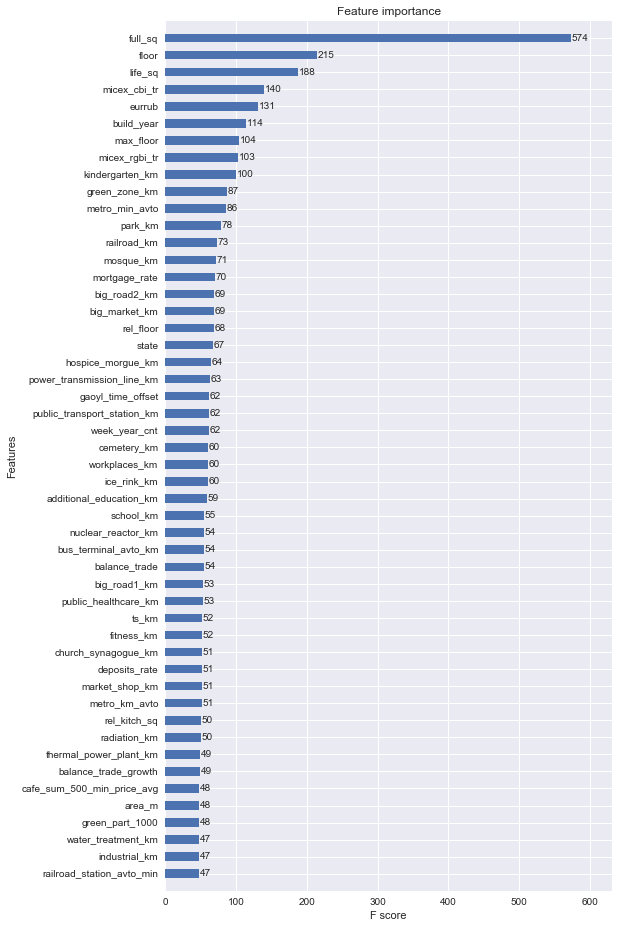

In [127]:
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(partial_model, max_num_features=50, height=0.5, ax=ax)

## correlation analysis

D:\Anaconda2\lib\site-packages\seaborn\matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
D:\Anaconda2\lib\site-packages\seaborn\matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


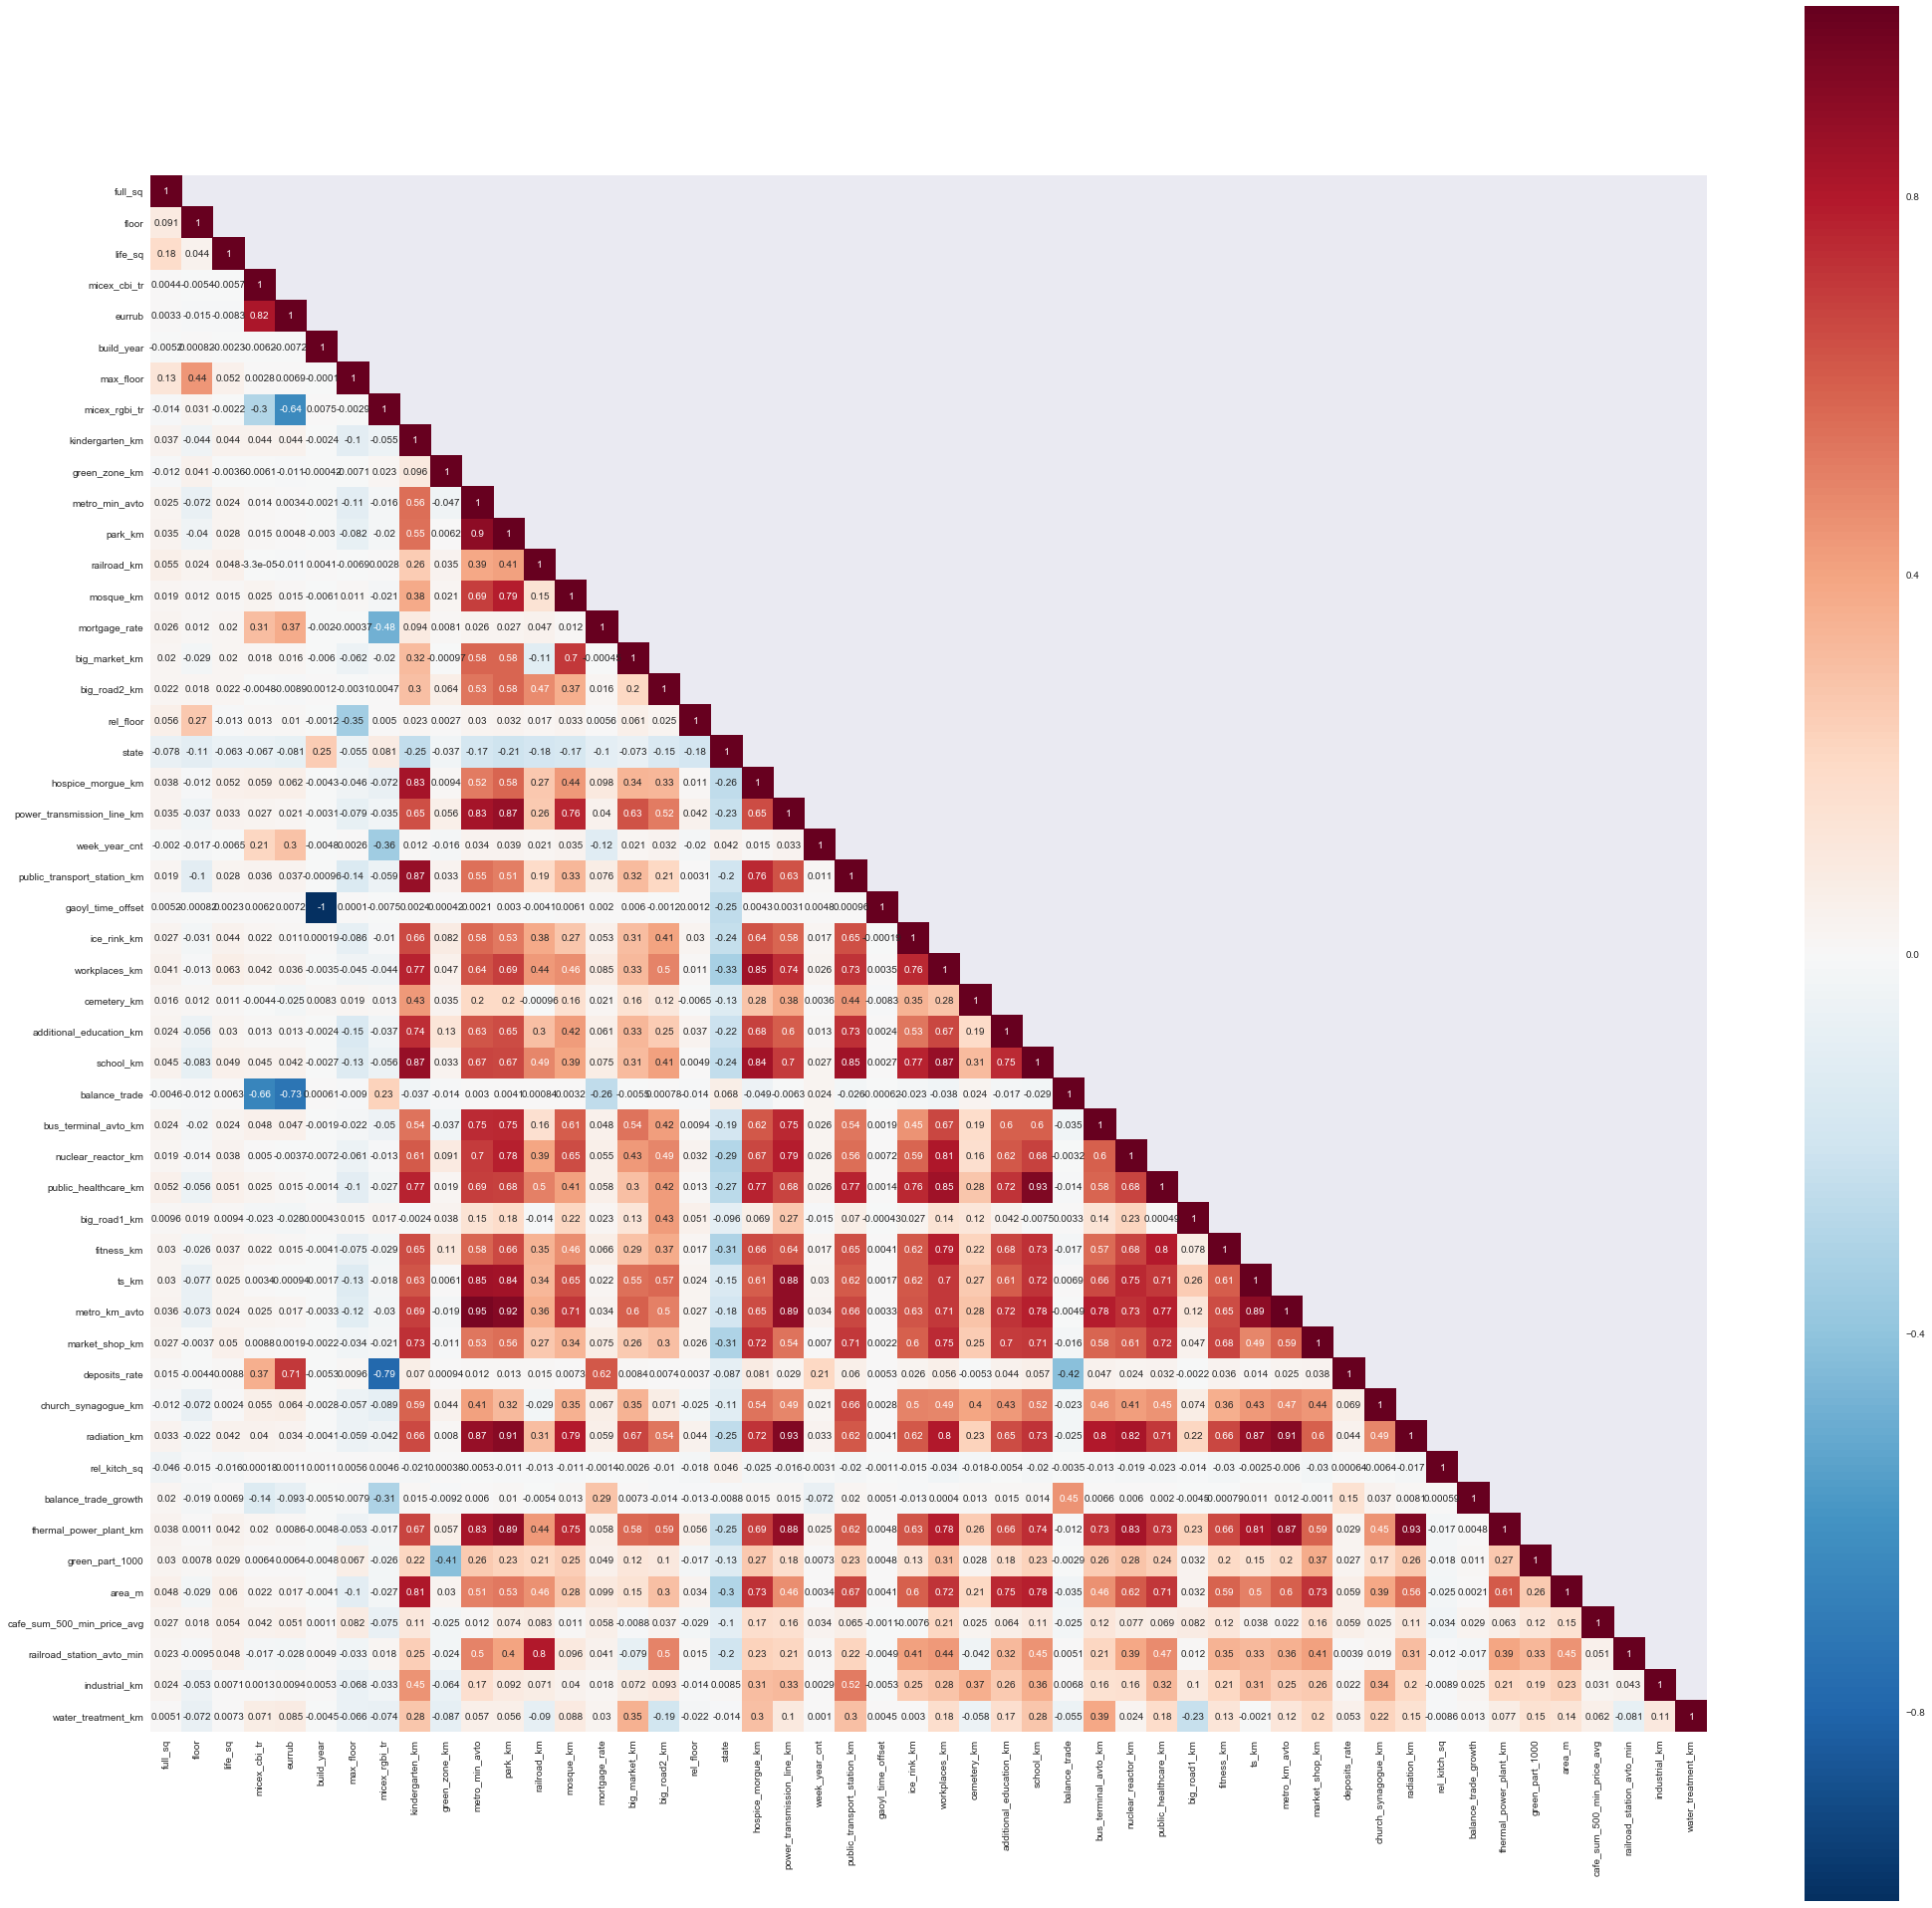

In [128]:
partial_model_fscore = partial_model.get_fscore()
partial_model_fscore = sorted(partial_model_fscore.items(), key=lambda x: x[1], reverse=True)
top_features = map(lambda x: x[0], partial_model_fscore[:50])
# top_features.append('price_doc')

corr_matt = df_all[top_features].corr()
mask = np.array(corr_matt)
mask[np.tril_indices_from(mask)] = False
plt.figure(figsize=(35, 35))
sns.heatmap(corr_matt, mask=mask, vmax=.8, square=True, annot=True)

## best round

In [129]:
num_boost_round = partial_model.best_iteration
model = xgb.train(dict(xgb_params, silent=0), dtrain_all, num_boost_round=num_boost_round)

## best round feature importance

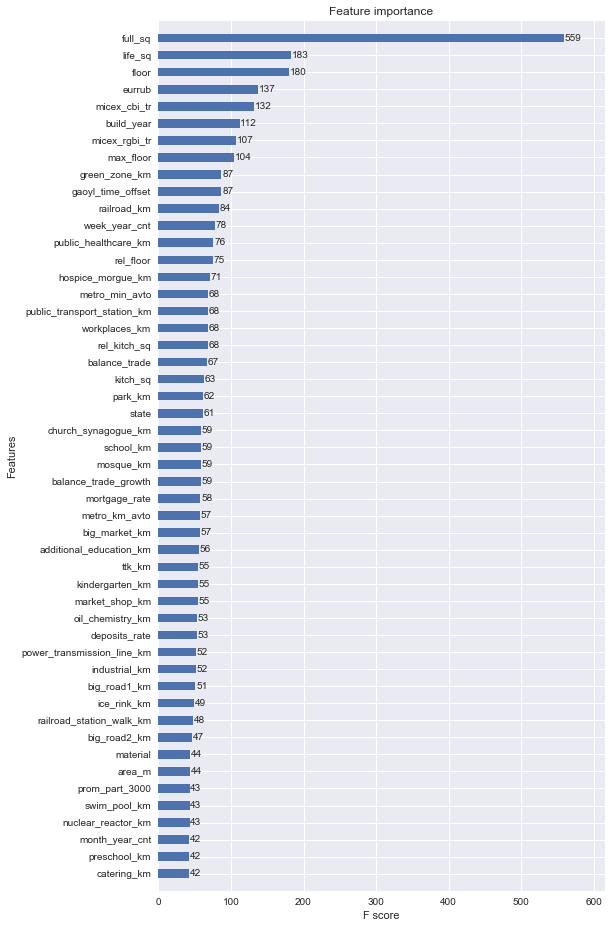

In [130]:
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

# prediction

In [131]:
ylog_pred = model.predict(dtest)
y_pred = np.exp(ylog_pred) - 1

df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred})

df_sub.to_csv('../output/sub_{}_{}.csv'.format('naive', int(time.time())), index=False)